# 02 - Train ConvNeXt-V2 Nano

Train **ConvNeXt-V2 Nano** on the plant disease subset with full checkpoint save/resume support.

**Prerequisites:** Run `01_prepare_data.ipynb` first to create `data/subset/{train,val,test}/`.

**Pipeline:**

1. Load dataset & build dataloaders
2. Create ConvNeXt-V2 Nano model (ImageNet pretrained)
3. Train with per-epoch checkpointing (auto-resume on disconnect)
4. Evaluate on test set with classification report
5. Visualize: learning curves, confusion matrix, prediction grid

**Runtime:** Set `RUNTIME = "mac"` or `RUNTIME = "colab"` in the config cell below.

| Setting | Mac (MPS) | Colab (CUDA) |
|---------|-----------|--------------|
| Device | `mps` | `cuda` |
| Batch size | 16 | 32 |
| FP16 | Off | On |
| num_workers | 0 | 2 |
| pin_memory | False | True |

## 1. Setup


In [1]:
!pip install -q timm albumentations


[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
# Ensure CWD is the project root
# Works on both Colab and local Jupyter
import os
from pathlib import Path


def find_project_root():
    """Find project root by looking for data/subset directory"""
    current = Path(os.getcwd()).resolve()

    # Check if we're already in project root
    if (current / "data" / "subset").is_dir():
        return current

    # Check if we're in notebooks/ subdirectory
    if current.name == "notebooks":
        parent = current.parent
        if (parent / "data" / "subset").is_dir():
            return parent

    # Search upward from current directory
    for parent in current.parents:
        if (parent / "data" / "subset").is_dir():
            return parent

    # On Colab, search /content for project directories
    if current == Path("/content") or str(current).startswith("/content"):
        content_dir = Path("/content")
        if content_dir.exists():
            # Try common repo name first
            colab_repo = content_dir / "plant-disease-classification"
            if colab_repo.exists() and (colab_repo / "data" / "subset").is_dir():
                return colab_repo
            # Search for any directory containing data/subset
            for item in content_dir.iterdir():
                if item.is_dir() and (item / "data" / "subset").is_dir():
                    return item

    # If still not found, return current and let the assertion fail with a helpful message
    return current


PROJECT_ROOT = find_project_root()
os.chdir(PROJECT_ROOT)
print(f"Working directory: {os.getcwd()}")
print(f"Looking for data/subset in: {PROJECT_ROOT / 'data' / 'subset'}")

# Check if data/subset exists
if not (PROJECT_ROOT / "data" / "subset").is_dir():
    # Provide helpful diagnostics
    print(f"\n⚠️  data/subset not found in {PROJECT_ROOT}")
    print(f"\nDiagnostics:")
    print(f"  - Current directory: {os.getcwd()}")
    if (PROJECT_ROOT / "data").is_dir():
        print(
            f"  - data/ directory exists, contents: {list((PROJECT_ROOT / 'data').iterdir())[:5]}"
        )
    else:
        print(f"  - data/ directory not found")

    # On Colab, check if repo needs to be cloned
    if Path("/content").exists():
        print(f"\n💡 On Colab? Try:")
        print(f"  1. Clone the repo: !git clone <your-repo-url>")
        print(f"  2. Then: %cd plant-disease-classification")
        print(f"  3. Run 01_prepare_data.ipynb first to create data/subset")

    raise AssertionError(
        f"data/subset not found in {PROJECT_ROOT}.\n"
        f"Please run 01_prepare_data.ipynb first to create the subset, or ensure the project is set up correctly."
    )

print("✅ Project root found and data/subset exists!")

Working directory: /Users/phuochuynh/Documents/1.LearningMaster/CV/plant-disease-classification
Looking for data/subset in: /Users/phuochuynh/Documents/1.LearningMaster/CV/plant-disease-classification/data/subset
✅ Project root found and data/subset exists!


## 2. Imports


In [3]:
import os
import random
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from torch.utils.data import DataLoader, Dataset

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

/Users/phuochuynh/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch: 2.8.0
CUDA available: False


## 3. Configuration

**Change `RUNTIME` below** to switch between Mac (MPS) and Colab (CUDA).  
All device-specific settings (batch size, workers, fp16, etc.) are set automatically.

In [4]:
# ======================================================
# >>> CHANGE THIS to switch runtime <<<
# Options: "mac" (Apple Silicon MPS) or "colab" (CUDA GPU)
RUNTIME = "mac"
# ======================================================

# Preset settings per runtime
_RUNTIME_PRESETS = {
    "mac": dict(
        batch_size=16,
        num_workers=0,
        pin_memory=False,
        use_fp16=False,
    ),
    "colab": dict(
        batch_size=32,
        num_workers=2,
        pin_memory=True,
        use_fp16=True,
    ),
}

assert RUNTIME in _RUNTIME_PRESETS, f"Invalid RUNTIME '{RUNTIME}'. Choose 'mac' or 'colab'."
_preset = _RUNTIME_PRESETS[RUNTIME]
print(f"Runtime: {RUNTIME.upper()} — {_preset}")


@dataclass
class TrainConfig:
    """Configuration for training, evaluation, and visualization."""

    # --- Paths (must match 01_prepare_data output) ---
    subset_dir: str = "data/subset"
    checkpoint_dir: str = "outputs/checkpoints"
    figure_dir: str = "outputs/figures"

    # --- Model ---
    model_name: str = "convnextv2_nano"
    pretrained: bool = True

    # --- Training ---
    epochs: int = 10
    batch_size: int = _preset["batch_size"]
    lr: float = 1e-4
    weight_decay: float = 0.05
    label_smoothing: float = 0.1
    use_fp16: bool = _preset["use_fp16"]

    # --- Scheduler ---
    T_0: int = 10
    T_mult: int = 2
    eta_min: float = 1e-6

    # --- Data ---
    image_size: int = 224
    num_workers: int = _preset["num_workers"]
    pin_memory: bool = _preset["pin_memory"]

    # --- CLAHE ---
    clahe_clip_limit: float = 2.0
    clahe_tile_grid: Tuple[int, int] = (8, 8)

    # --- Reproducibility ---
    seed: int = 42

    # --- Resume ---
    resume: bool = True


cfg = TrainConfig()
print(cfg)

Runtime: MAC — {'batch_size': 16, 'num_workers': 0, 'pin_memory': False, 'use_fp16': False}
TrainConfig(subset_dir='data/subset', checkpoint_dir='outputs/checkpoints', figure_dir='outputs/figures', model_name='convnextv2_nano', pretrained=True, epochs=10, batch_size=16, lr=0.0001, weight_decay=0.05, label_smoothing=0.1, use_fp16=False, T_0=10, T_mult=2, eta_min=1e-06, image_size=224, num_workers=0, pin_memory=False, clahe_clip_limit=2.0, clahe_tile_grid=(8, 8), seed=42, resume=True)


### Reproducibility & Device

Device is selected based on `RUNTIME` above. Falls back to CPU if the expected hardware is unavailable.

In [5]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


seed_everything(cfg.seed)

# Select device based on RUNTIME setting
if RUNTIME == "colab":
    if torch.cuda.is_available():
        DEVICE = torch.device("cuda")
        print(f"Device: CUDA ({torch.cuda.get_device_name(0)})")
    else:
        DEVICE = torch.device("cpu")
        cfg.use_fp16 = False
        print("WARNING: RUNTIME='colab' but CUDA not available — falling back to CPU")

elif RUNTIME == "mac":
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        DEVICE = torch.device("mps")
        print("Device: MPS (Apple Silicon)")
    else:
        DEVICE = torch.device("cpu")
        print("WARNING: RUNTIME='mac' but MPS not available — falling back to CPU")

print(f"Settings: batch_size={cfg.batch_size}, num_workers={cfg.num_workers}, "
      f"pin_memory={cfg.pin_memory}, fp16={cfg.use_fp16}")

for d in [cfg.checkpoint_dir, cfg.figure_dir]:
    os.makedirs(d, exist_ok=True)

Device: MPS (Apple Silicon)
Settings: batch_size=16, num_workers=0, pin_memory=False, fp16=False


## 4. Dataset & DataLoaders

Loads the subset created by `01_prepare_data.ipynb`.  
Re-defines `PlantDiseaseDataset` and `TransformFactory` so this notebook is self-contained.


In [6]:
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


class PlantDiseaseDataset(Dataset):
    """Dataset for class-per-folder image layout."""

    def __init__(self, root_dir: str, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples: List[Tuple[str, int]] = []
        self.classes: List[str] = []
        self.class_to_idx: Dict[str, int] = {}
        self._scan()

    def _scan(self):
        self.classes = sorted(
            d
            for d in os.listdir(self.root_dir)
            if os.path.isdir(os.path.join(self.root_dir, d))
        )
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            for fname in sorted(os.listdir(cls_dir)):
                if os.path.splitext(fname)[1].lower() in IMAGE_EXTS:
                    self.samples.append(
                        (os.path.join(cls_dir, fname), self.class_to_idx[cls])
                    )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = np.array(Image.open(path).convert("RGB"))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label


class TransformFactory:
    """Albumentations pipelines with CLAHE preprocessing."""

    def __init__(self, cfg: TrainConfig):
        self.cfg = cfg

    def train(self) -> A.Compose:
        return A.Compose(
            [
                A.Resize(self.cfg.image_size, self.cfg.image_size),
                A.CLAHE(
                    clip_limit=self.cfg.clahe_clip_limit,
                    tile_grid_size=self.cfg.clahe_tile_grid,
                    p=1.0,
                ),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(
                    shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.5
                ),
                A.ColorJitter(
                    brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5
                ),
                A.GaussNoise(p=0.3),
                A.GaussianBlur(blur_limit=(3, 7), p=0.2),
                A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ToTensorV2(),
            ]
        )

    def val(self) -> A.Compose:
        return A.Compose(
            [
                A.Resize(self.cfg.image_size, self.cfg.image_size),
                A.CLAHE(
                    clip_limit=self.cfg.clahe_clip_limit,
                    tile_grid_size=self.cfg.clahe_tile_grid,
                    p=1.0,
                ),
                A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ToTensorV2(),
            ]
        )

In [7]:
# Verify subset exists
for split in ["train", "val", "test"]:
    p = os.path.join(cfg.subset_dir, split)
    assert os.path.isdir(p), f"Missing {p} — run 01_prepare_data.ipynb first!"

tf = TransformFactory(cfg)

train_dataset = PlantDiseaseDataset(
    os.path.join(cfg.subset_dir, "train"), transform=tf.train()
)
val_dataset = PlantDiseaseDataset(
    os.path.join(cfg.subset_dir, "val"), transform=tf.val()
)
test_dataset = PlantDiseaseDataset(
    os.path.join(cfg.subset_dir, "test"), transform=tf.val()
)

CLASS_NAMES = train_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)

print(f"Classes ({NUM_CLASSES}): {CLASS_NAMES}")
print(
    f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}"
)

train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
)

Classes (7): ['downy mildew', 'early blight', 'gray mold', 'green mold', 'late blight', 'powdery mildew', 'tomato mosaic virus']
Train: 350 | Val: 105 | Test: 70


/Users/phuochuynh/Library/Python/3.9/lib/python/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## 5. Model

ConvNeXt-V2 Nano via `timm` with ImageNet pretrained weights.  
Classifier head automatically matches `num_classes`.


In [8]:
class ModelFactory:
    """Build and inspect classification models."""

    @staticmethod
    def create(model_name: str, num_classes: int, pretrained: bool = True) -> nn.Module:
        return timm.create_model(
            model_name, pretrained=pretrained, num_classes=num_classes
        )

    @staticmethod
    def count_parameters(model: nn.Module) -> int:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    @staticmethod
    def get_size_mb(model: nn.Module) -> float:
        param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
        buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
        return (param_size + buffer_size) / (1024**2)


model = ModelFactory.create(cfg.model_name, NUM_CLASSES, cfg.pretrained).to(DEVICE)

print(f"Model: {cfg.model_name}")
print(f"Parameters: {ModelFactory.count_parameters(model):,}")
print(f"Size: {ModelFactory.get_size_mb(model):.2f} MB")

Model: convnextv2_nano
Parameters: 14,987,287
Size: 57.17 MB


## 6. Trainer (Checkpoint Save & Resume)

The `Trainer` class manages the full training loop with **resilience to disconnects**:

| Feature         | Detail                                                                  |
| --------------- | ----------------------------------------------------------------------- |
| Per-epoch save  | `latest_checkpoint.pth` — model, optimizer, scheduler, scaler, history  |
| Best model      | `convnextv2_nano_best.pth` — best by validation macro F1                |
| Auto-resume     | If checkpoint exists, restores full state and continues from next epoch |
| Mixed precision | FP16 via `torch.amp.GradScaler` on CUDA                                 |

If Colab disconnects mid-training, **just re-run the training cell** — it resumes automatically.


In [9]:
class Trainer:
    """Training loop with per-epoch checkpoint save/resume and mixed precision."""

    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        cfg: TrainConfig,
        device: torch.device,
        class_names: List[str],
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.cfg = cfg
        self.device = device
        self.class_names = class_names

        self.criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)
        self.optimizer = torch.optim.AdamW(
            model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=cfg.T_0, T_mult=cfg.T_mult, eta_min=cfg.eta_min
        )

        # Mixed precision — only on CUDA
        self.use_amp = cfg.use_fp16 and device.type == "cuda"
        self.scaler = torch.amp.GradScaler(device.type, enabled=self.use_amp)

        self.start_epoch = 1
        self.best_f1 = 0.0
        self.history: Dict[str, List[float]] = {
            "train_loss": [], "val_loss": [],
            "train_acc": [], "val_acc": [],
            "val_f1": [],
        }

        self.ckpt_dir = Path(cfg.checkpoint_dir)
        self.latest_path = self.ckpt_dir / "latest_checkpoint.pth"
        self.best_path = self.ckpt_dir / "convnextv2_nano_best.pth"

        if cfg.resume:
            self._try_resume()

    # --- Checkpoint ---

    def _save_checkpoint(self, epoch: int, is_best: bool = False):
        """Save full training state after each epoch."""
        state = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "scheduler_state_dict": self.scheduler.state_dict(),
            "scaler_state_dict": self.scaler.state_dict(),
            "best_f1": self.best_f1,
            "history": self.history,
            "class_names": self.class_names,
            "num_classes": len(self.class_names),
            "config": {
                "model_name": self.cfg.model_name,
                "lr": self.cfg.lr,
                "epochs": self.cfg.epochs,
                "batch_size": self.cfg.batch_size,
            },
        }
        torch.save(state, self.latest_path)
        if is_best:
            torch.save(state, self.best_path)

    def _try_resume(self):
        """Resume from latest checkpoint if available."""
        if not self.latest_path.exists():
            print("[resume] No checkpoint found, starting from scratch.")
            return

        print(f"[resume] Loading: {self.latest_path}")
        ckpt = torch.load(self.latest_path, map_location=self.device, weights_only=False)

        self.model.load_state_dict(ckpt["model_state_dict"])
        self.optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        self.scheduler.load_state_dict(ckpt["scheduler_state_dict"])
        self.scaler.load_state_dict(ckpt["scaler_state_dict"])
        self.best_f1 = ckpt["best_f1"]
        self.history = ckpt["history"]
        self.start_epoch = ckpt["epoch"] + 1

        print(f"[resume] Continuing from epoch {self.start_epoch} (best F1={self.best_f1:.4f})")

    # --- Train / evaluate ---

    def _train_one_epoch(self) -> Tuple[float, float]:
        self.model.train()
        running_loss = 0.0
        all_preds, all_targets = [], []

        for images, labels in self.train_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()

            with torch.amp.autocast(self.device.type, enabled=self.use_amp):
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            running_loss += loss.item() * images.size(0)
            all_preds.append(outputs.argmax(1).cpu().numpy())
            all_targets.append(labels.cpu().numpy())

        preds = np.concatenate(all_preds)
        targets = np.concatenate(all_targets)
        return running_loss / len(targets), accuracy_score(targets, preds)

    @torch.no_grad()
    def _evaluate(self, loader: DataLoader) -> Tuple[float, float, float, np.ndarray, np.ndarray]:
        self.model.eval()
        running_loss = 0.0
        all_preds, all_targets = [], []

        for images, labels in loader:
            images, labels = images.to(self.device), labels.to(self.device)

            with torch.amp.autocast(self.device.type, enabled=self.use_amp):
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            all_preds.append(outputs.argmax(1).cpu().numpy())
            all_targets.append(labels.cpu().numpy())

        preds = np.concatenate(all_preds)
        targets = np.concatenate(all_targets)
        return (
            running_loss / len(targets),
            accuracy_score(targets, preds),
            f1_score(targets, preds, average="macro"),
            preds,
            targets,
        )

    # --- Main loop ---

    def train(self):
        """Run training with per-epoch checkpointing."""
        if self.start_epoch > self.cfg.epochs:
            print(f"[train] Already completed {self.cfg.epochs} epochs.")
            print("  Increase cfg.epochs or delete checkpoints to retrain.")
            return

        amp_str = "ON" if self.use_amp else "OFF"
        print(f"\n{'='*65}")
        print(f"  Training {self.cfg.model_name}")
        print(
            f"  Epochs: {self.start_epoch}..{self.cfg.epochs} | "
            f"BS: {self.cfg.batch_size} | LR: {self.cfg.lr} | FP16: {amp_str}"
        )
        print(f"{'='*65}\n")

        for epoch in range(self.start_epoch, self.cfg.epochs + 1):
            t0 = time.time()

            train_loss, train_acc = self._train_one_epoch()
            val_loss, val_acc, val_f1, _, _ = self._evaluate(self.val_loader)
            self.scheduler.step()

            elapsed = time.time() - t0
            lr_now = self.optimizer.param_groups[0]["lr"]

            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_acc"].append(val_acc)
            self.history["val_f1"].append(val_f1)

            is_best = val_f1 > self.best_f1
            if is_best:
                self.best_f1 = val_f1

            self._save_checkpoint(epoch, is_best=is_best)

            marker = " *BEST*" if is_best else ""
            print(
                f"Epoch {epoch:02d}/{self.cfg.epochs} | "
                f"Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f}  F1: {val_f1:.4f} | "
                f"LR: {lr_now:.2e} | {elapsed:.1f}s{marker}"
            )

        print(f"\nTraining complete. Best Val F1: {self.best_f1:.4f}")
        print(f"  Latest: {self.latest_path}")
        print(f"  Best:   {self.best_path}")

### Run training

Re-run this cell after a disconnect — it auto-resumes from the last completed epoch.


In [10]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    cfg=cfg,
    device=DEVICE,
    class_names=CLASS_NAMES,
)
trainer.train()

[resume] No checkpoint found, starting from scratch.

  Training convnextv2_nano
  Epochs: 1..10 | BS: 16 | LR: 0.0001 | FP16: OFF

Epoch 01/10 | Train Loss: 1.3730  Acc: 0.5657 | Val Loss: 0.7633  Acc: 0.8952  F1: 0.8929 | LR: 9.76e-05 | 9.6s *BEST*
Epoch 02/10 | Train Loss: 0.7936  Acc: 0.8457 | Val Loss: 0.6338  Acc: 0.9429  F1: 0.9430 | LR: 9.05e-05 | 8.8s *BEST*
Epoch 03/10 | Train Loss: 0.6684  Acc: 0.9029 | Val Loss: 0.5747  Acc: 0.9429  F1: 0.9426 | LR: 7.96e-05 | 8.7s
Epoch 04/10 | Train Loss: 0.6294  Acc: 0.9314 | Val Loss: 0.5837  Acc: 0.9714  F1: 0.9713 | LR: 6.58e-05 | 8.7s *BEST*
Epoch 05/10 | Train Loss: 0.5448  Acc: 0.9714 | Val Loss: 0.5569  Acc: 0.9714  F1: 0.9714 | LR: 5.05e-05 | 8.7s *BEST*
Epoch 06/10 | Train Loss: 0.5513  Acc: 0.9571 | Val Loss: 0.5259  Acc: 0.9905  F1: 0.9905 | LR: 3.52e-05 | 8.7s *BEST*
Epoch 07/10 | Train Loss: 0.5365  Acc: 0.9714 | Val Loss: 0.5610  Acc: 0.9714  F1: 0.9713 | LR: 2.14e-05 | 8.7s
Epoch 08/10 | Train Loss: 0.5121  Acc: 0.9857 | V

## 7. Evaluator

Loads the **best checkpoint** (by val F1) and evaluates on the held-out test set.


In [11]:
class Evaluator:
    """Load best model and run test evaluation."""

    def __init__(self, model: nn.Module, test_loader: DataLoader,
                 cfg: TrainConfig, device: torch.device, class_names: List[str]):
        self.model = model
        self.test_loader = test_loader
        self.cfg = cfg
        self.device = device
        self.class_names = class_names
        self.criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)
        self.test_preds = None
        self.test_targets = None
        self.test_acc = None
        self.test_f1 = None

    def load_best_checkpoint(self):
        path = Path(self.cfg.checkpoint_dir) / "convnextv2_nano_best.pth"
        ckpt = torch.load(path, map_location=self.device, weights_only=False)
        self.model.load_state_dict(ckpt["model_state_dict"])
        print(f"[eval] Loaded best model from epoch {ckpt['epoch']} (F1={ckpt['best_f1']:.4f})")

    @torch.no_grad()
    def evaluate(self):
        self.model.eval()
        running_loss = 0.0
        all_preds, all_targets = [], []
        use_amp = self.cfg.use_fp16 and self.device.type == "cuda"

        for images, labels in self.test_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            with torch.amp.autocast(self.device.type, enabled=use_amp):
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            all_preds.append(outputs.argmax(1).cpu().numpy())
            all_targets.append(labels.cpu().numpy())

        self.test_preds = np.concatenate(all_preds)
        self.test_targets = np.concatenate(all_targets)
        self.test_acc = accuracy_score(self.test_targets, self.test_preds)
        self.test_f1 = f1_score(self.test_targets, self.test_preds, average="macro")
        avg_loss = running_loss / len(self.test_targets)

        print(f"\n{'='*65}")
        print(f"  Test Results")
        print(f"{'='*65}")
        print(f"  Loss: {avg_loss:.4f}  |  Acc: {self.test_acc:.4f}  |  Macro-F1: {self.test_f1:.4f}")
        print(f"{'='*65}\n")
        print(classification_report(
            self.test_targets, self.test_preds, target_names=self.class_names,
        ))

In [12]:
evaluator = Evaluator(model, test_loader, cfg, DEVICE, CLASS_NAMES)
evaluator.load_best_checkpoint()
evaluator.evaluate()

[eval] Loaded best model from epoch 6 (F1=0.9905)

  Test Results
  Loss: 0.5101  |  Acc: 0.9857  |  Macro-F1: 0.9857

                     precision    recall  f1-score   support

       downy mildew       1.00      1.00      1.00        10
       early blight       1.00      1.00      1.00        10
          gray mold       1.00      1.00      1.00        10
         green mold       1.00      1.00      1.00        10
        late blight       0.91      1.00      0.95        10
     powdery mildew       1.00      1.00      1.00        10
tomato mosaic virus       1.00      0.90      0.95        10

           accuracy                           0.99        70
          macro avg       0.99      0.99      0.99        70
       weighted avg       0.99      0.99      0.99        70



## 8. Visualizer

Three plots:

1. **Learning curves** — train/val loss and accuracy
2. **Confusion matrix** — true vs predicted heatmap
3. **Prediction grid** — 4x4 sample images (green = correct, red = wrong)


In [13]:
class Visualizer:
    """Generate and save training/evaluation plots."""

    def __init__(self, cfg: TrainConfig, class_names: List[str]):
        self.fig_dir = Path(cfg.figure_dir)
        self.fig_dir.mkdir(parents=True, exist_ok=True)
        self.class_names = class_names

    def plot_learning_curves(self, history: Dict[str, List[float]]):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        epochs = range(1, len(history["train_loss"]) + 1)

        ax1.plot(epochs, history["train_loss"], label="Train Loss")
        ax1.plot(epochs, history["val_loss"], label="Val Loss")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.set_title("Loss Curves")
        ax1.legend()
        ax1.grid(True)

        ax2.plot(epochs, history["train_acc"], label="Train Acc")
        ax2.plot(epochs, history["val_acc"], label="Val Acc")
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")
        ax2.set_title("Accuracy Curves")
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        path = self.fig_dir / "convnextv2_learning_curves.png"
        plt.savefig(path, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"Saved: {path}")

    def plot_confusion_matrix(self, preds: np.ndarray, targets: np.ndarray):
        cm = confusion_matrix(targets, preds)
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=self.class_names,
            yticklabels=self.class_names,
            ax=ax,
        )
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title("Confusion Matrix")
        plt.tight_layout()
        path = self.fig_dir / "convnextv2_confusion_matrix.png"
        plt.savefig(path, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"Saved: {path}")

    def plot_prediction_grid(
        self,
        model: nn.Module,
        dataset: Dataset,
        device: torch.device,
        n_samples: int = 16,
        seed: int = 42,
    ):
        rng = random.Random(seed)
        indices = rng.sample(range(len(dataset)), min(n_samples, len(dataset)))
        mean, std = np.array(IMAGENET_MEAN), np.array(IMAGENET_STD)

        model.eval()
        fig, axes = plt.subplots(4, 4, figsize=(16, 16))
        axes = axes.flatten()

        for ax_i, data_i in enumerate(indices):
            img_t, label = dataset[data_i]
            with torch.no_grad():
                logits = model(img_t.unsqueeze(0).to(device))
                probs = torch.softmax(logits, 1)
                conf, pred = probs.max(1)
                pred, conf = pred.item(), conf.item()

            img_np = np.clip(img_t.permute(1, 2, 0).numpy() * std + mean, 0, 1)
            correct = pred == label

            axes[ax_i].imshow(img_np)
            axes[ax_i].set_title(
                f"True: {self.class_names[label]}\nPred: {self.class_names[pred]} ({conf:.1%})",
                color="green" if correct else "red",
                fontsize=9,
            )
            axes[ax_i].axis("off")

        for ax_i in range(len(indices), len(axes)):
            axes[ax_i].axis("off")

        plt.suptitle("ConvNeXt-V2 Nano \u2014 Sample Predictions", fontsize=14, y=1.01)
        plt.tight_layout()
        path = self.fig_dir / "convnextv2_predictions.png"
        plt.savefig(path, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"Saved: {path}")

### Generate visualizations


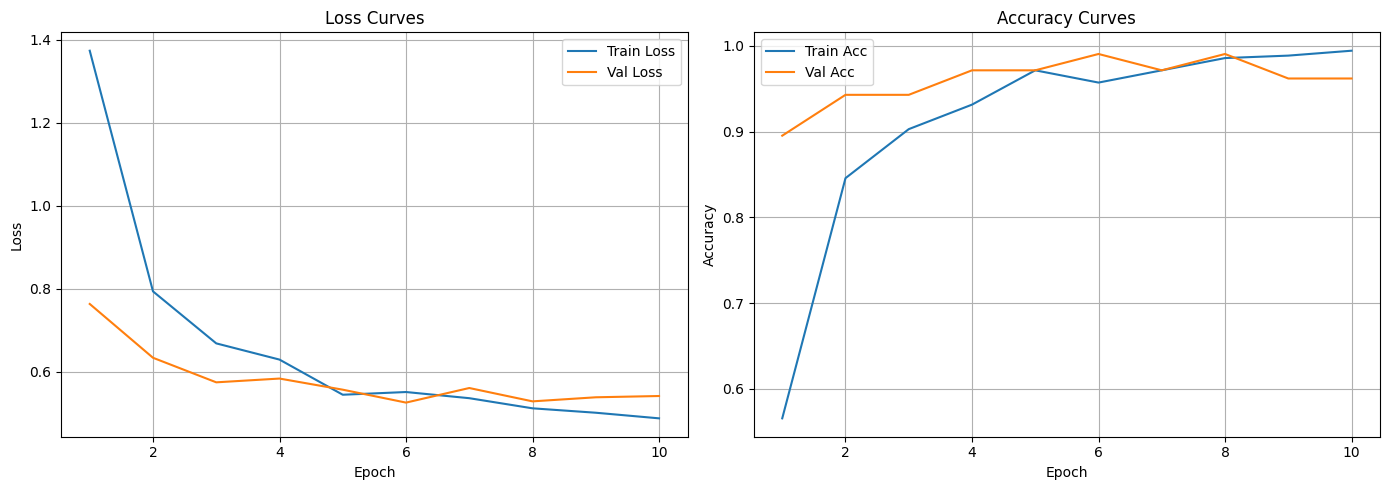

Saved: outputs/figures/convnextv2_learning_curves.png


In [14]:
viz = Visualizer(cfg, CLASS_NAMES)
viz.plot_learning_curves(trainer.history)

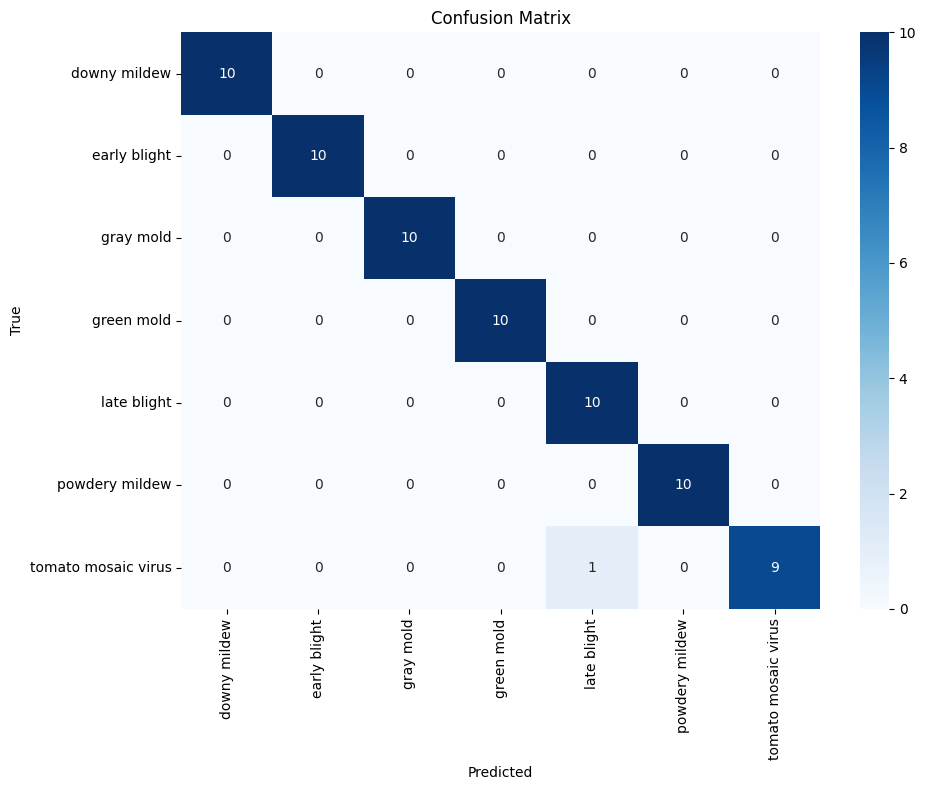

Saved: outputs/figures/convnextv2_confusion_matrix.png


In [15]:
viz.plot_confusion_matrix(evaluator.test_preds, evaluator.test_targets)

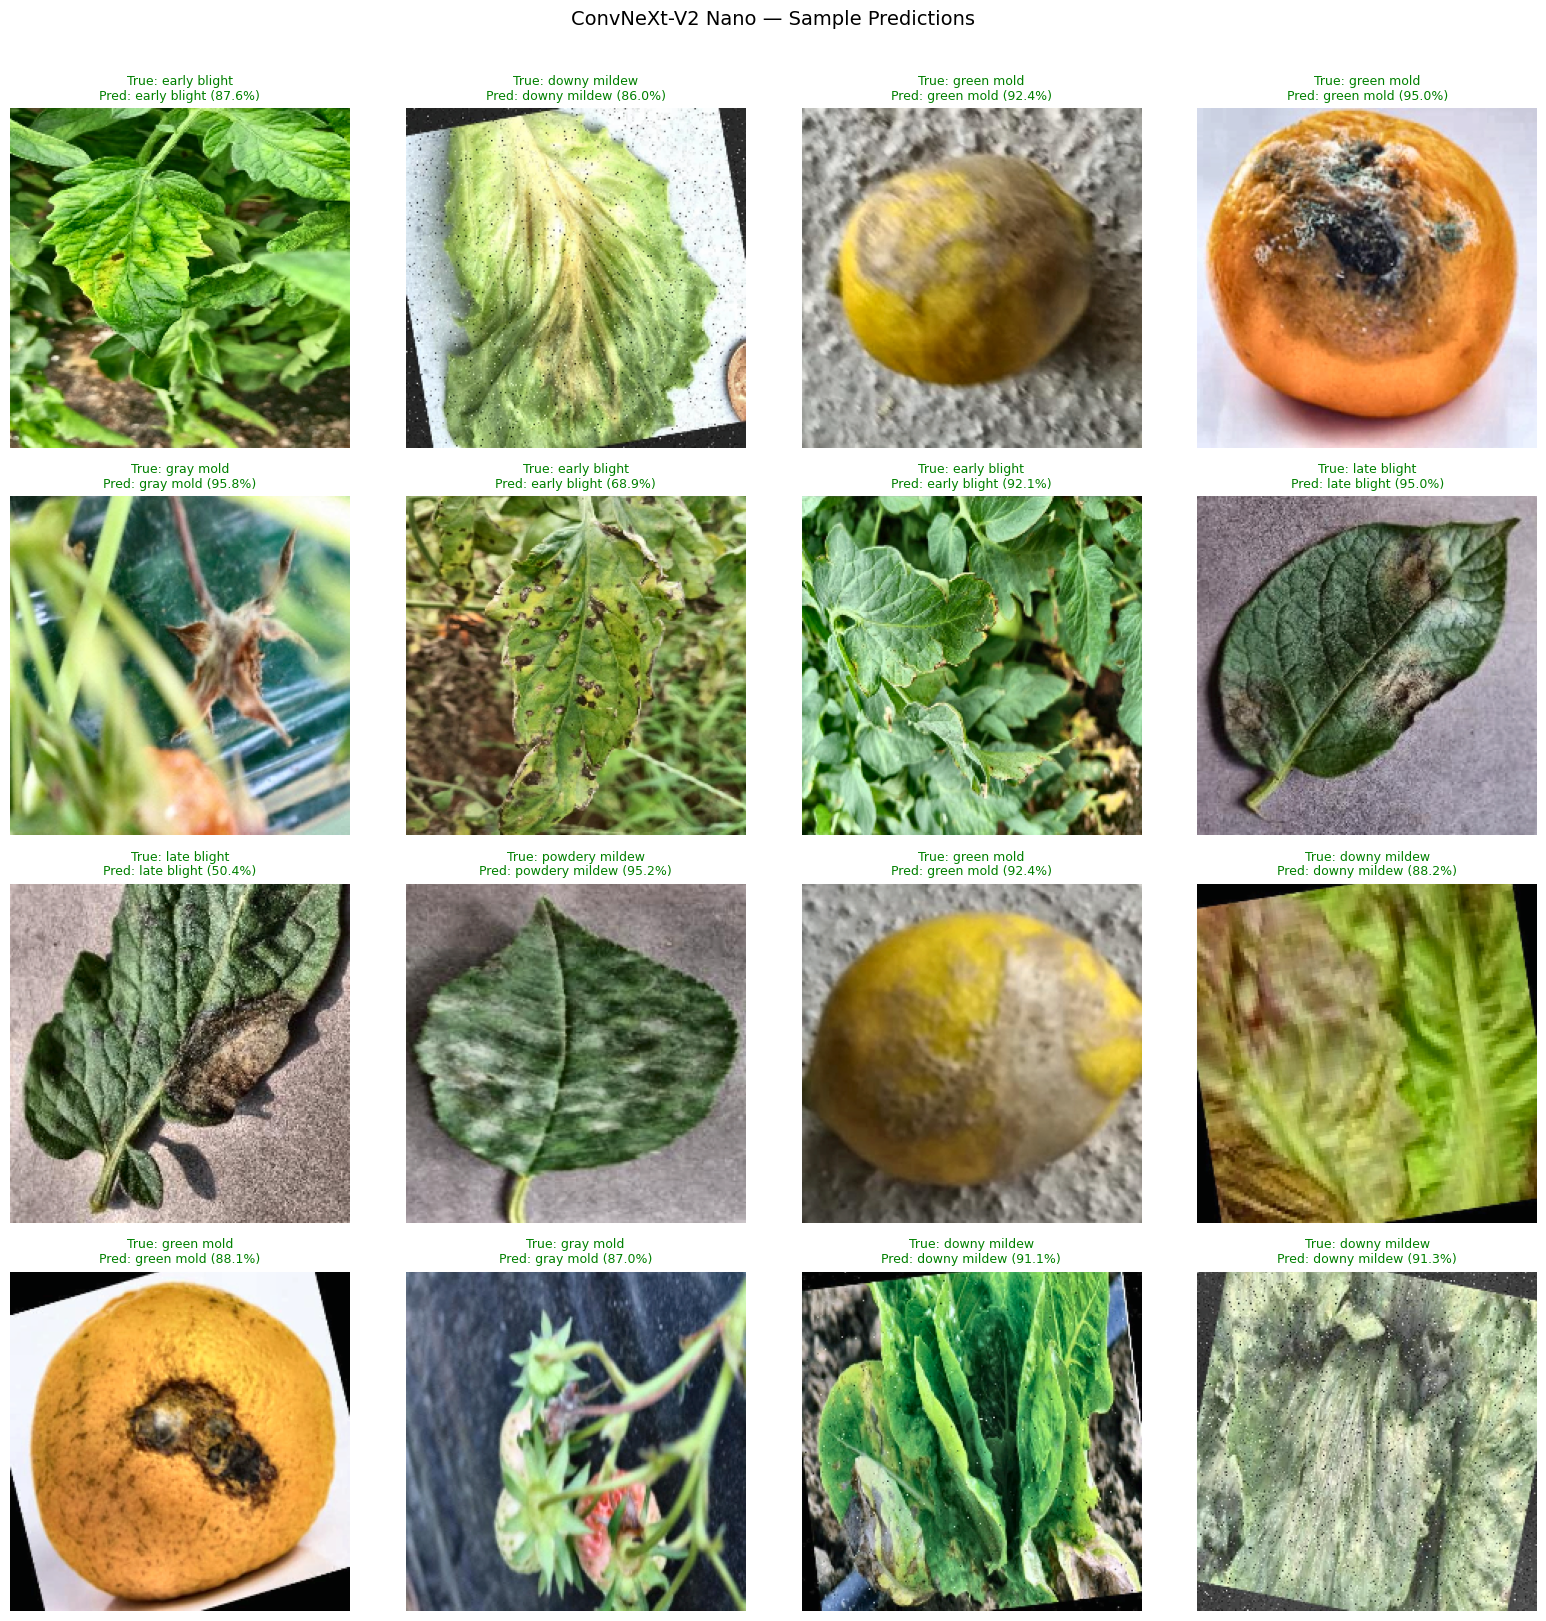

Saved: outputs/figures/convnextv2_predictions.png


In [16]:
viz.plot_prediction_grid(model, test_dataset, DEVICE)

## 9. Summary


In [17]:
print(f"{'='*65}")
print(f"  Final Summary")
print(f"{'='*65}")
print(f"  Model:          {cfg.model_name}")
print(f"  Parameters:     {ModelFactory.count_parameters(model):,}")
print(f"  Model size:     {ModelFactory.get_size_mb(model):.2f} MB")
print(f"  Epochs trained: {len(trainer.history['train_loss'])}")
print(f"  Best Val F1:    {trainer.best_f1:.4f}")
print(f"  Test Accuracy:  {evaluator.test_acc:.4f}")
print(f"  Test Macro-F1:  {evaluator.test_f1:.4f}")
print(f"{'='*65}")
print(f"  Checkpoints:    {cfg.checkpoint_dir}/")
print(f"  Figures:        {cfg.figure_dir}/")
print(f"{'='*65}")

  Final Summary
  Model:          convnextv2_nano
  Parameters:     14,987,287
  Model size:     57.17 MB
  Epochs trained: 10
  Best Val F1:    0.9905
  Test Accuracy:  0.9857
  Test Macro-F1:  0.9857
  Checkpoints:    outputs/checkpoints/
  Figures:        outputs/figures/
